In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, recall_score, make_scorer, ConfusionMatrixDisplay
import optuna
pd.set_option('display.max_columns', 200) # Display all columns

/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,tpaquete1,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,mdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolares,ctitulos,mtitulos,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,mbonos_corporativos,mmonedas_extranjeras,minversiones_otras,cplan_sueldo,mplan_sueldo,mplan_sueldo_manual,cplan_sueldo_transaccion,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,ccambio_monedas,ccambio_monedas_compra,mcambio_monedas_compra,ccambio_monedas_venta,mcambio_monedas_venta,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,thomebanking,chomebanking_transacciones,cautoservicio,cautoservicio_transacciones,tmovimientos_ultimos90dias,visa_marca_atraso,visa_mfinanciacion_limite,visa_msaldototal,visa_msaldopesos,visa_msaldodolares,visa_mconsumospesos,visa_mconsumosdolares,visa_mlimitecompra,visa_mpagado,visa_mpagospesos,visa_mpagosdolares,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0,visa_cuenta_estado_unknown
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,1,0,0,0,0,0,0,0,0,1.17,-460.04,2,2574.00,1,17,19451.75,1,18,17091.34,3,73704.79,0,0.0,0.0,0,0.0,0.0,0,0.00,0,1,0,0,0,0,0,1,56580.03,0.0,0,1,68.94,0,0.0,0,0.00,0,0.0,0.00,14,579.66,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,116,0.0,63180.0,29994.31,32262.86,2830.47,14555.47,59.47,70200.0,0.0,-19632.60,0.00,14555.47,13.0,3837.6,0,4206.0,False,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,1,0,0,0,0,0,0,0,0,1.17,6301.72,0,0.00,1,1,174.33,1,0,0.00,0,0.00,0,0.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,0,0.00,0,0.0,833.97,4,790.58,0,0,0.0,0,0.0,0,0.0,1,351.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,1,0,0,17,0.0,63180.0,182.45,213.46,0.00,-11.55,4.22,70200.0,0.0,-2976.51,62.78,-11.55,2.0,35.1,0,6862.0,False,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,1,0,0,0,0,0,0,0,0,1.17,45.63,0,0.00,1,8,11670.93,1,0,0.00,0,0.00,0,0.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,0,0.00,0,0.0,0.00,6,236.08,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0,0,0,10,0.0,176904.0,10367.71,12130.22,0.00,6788.67,0.00,196560.0,0.0,-12753.00,0.00,6788.67,4.0,1977.3,0,10317.0,False,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,1,0,0,0,0,0,0,0,0,1.17,5429.85,4,4103.69,1,9,9840.21,1,14,12383.23,0,0.00,0,0.0,0.0,0,0.0,0.0,3,10509.33,0,0,0,0,0,0,0,0,0.00,0.0,0,4,5303.31,0,0.0,0,0.00,2,2460.0,833.97,18,1280.47,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,78,0,0,85,0.0,176904.0,6754.10,7433.72,468.57,2946.70,10.51,196560.0,0.0,-3685.76,0.00,2946.70,5.0,573.3,0,3581.0,False,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,1,0,0,0,0,0,0,0,0,1.17,563006.87,10,4313.45,1,2,1496.03,1,0,0.00,0,0.00,1,351000.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,7,2171.89,1,

In [3]:
# Features and target
X = df.drop(columns=["clase_binaria"])
y = df["clase_binaria"]

Running the base model with optimized hyperparameters

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

# Define the objective function
def objective(trial):
    # Define the hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
    }

    # Create the model
    model = XGBClassifier(**params, random_state=12, use_label_encoder=False, eval_metric="logloss")
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
    return np.mean(cv_scores)

# Create the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the final model with the best parameters
best_params = study.best_params
final_model = XGBClassifier(**best_params, random_state=12, use_label_encoder=False, eval_metric="logloss")
final_model.fit(X_train, y_train)

# Evaluate the model
y_pred = final_model.predict(X_test)  # Get binary predictions
recall = recall_score(y_test, y_pred, pos_label=1)  # 'BAJA' is the churn class
print("Recall on test set:", recall)

# Also evaluate ROC AUC
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC on test set:", roc_auc)


[I 2024-11-24 14:55:45,691] A new study created in memory with name: no-name-5c57059b-6665-45fd-9cdd-1b615c6178d5
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "

Best hyperparameters: {'n_estimators': 271, 'max_depth': 10, 'learning_rate': 0.02200404623616381, 'subsample': 0.8369736390983421, 'colsample_bytree': 0.634767009562962, 'gamma': 4.7939310969608675, 'reg_alpha': 9.432803242810808, 'reg_lambda': 2.692488458821817, 'scale_pos_weight': 2.9517461601399075}


/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall on test set: 0.47956403269754766
ROC AUC on test set: 0.9425024397964397


### This first model is optimized for AUC. Even though the performance metric that will be used in the correction of this assessment is AUC, I can improve the recall significantly without having to compromise that much AUC.

The AUC score improves but the recall is very low. Need to optimize the model for recall which is important in churn prediction where missing a churned customer is costly.  
Also, the scale_pos_weight will be now dynamically set based on a heuristic derived from the class distribution of y_train. The heuristic is calculated as the ratio of the number of negative (0) samples to the number of positive (1) samples. This helps adjust the model for class imbalance more effectively.  
For cross-validation, I'll be using a custom recall scorer (make_scorer(recall_score)), emphasizing recall as the performance metric in cross-validation.

In [9]:
# Define the scale_pos_weight heuristic
scale_pos_weight_heuristic = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the objective function
def objective(trial):
    # Define the hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", scale_pos_weight_heuristic / 2, scale_pos_weight_heuristic * 2),
    }

    # Create the model
    model = XGBClassifier(**params, random_state=12, use_label_encoder=False, eval_metric="logloss")
    
    # Cross-validation score with recall as the metric
    recall_scorer = make_scorer(recall_score, average="binary", pos_label=1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=recall_scorer)
    return np.mean(cv_scores)

# Create the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the final model with the best parameters
best_params = study.best_params
final_model = XGBClassifier(**best_params, random_state=12, use_label_encoder=False, eval_metric="logloss")
final_model.fit(X_train, y_train)

# Evaluate the model
y_pred = final_model.predict(X_test)

# Calculate recall and classification report
final_recall = recall_score(y_test, y_pred, pos_label=1)
print("Recall on test set:", final_recall)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[I 2024-11-24 14:34:35,201] A new study created in memory with name: no-name-d0f3a83c-cebe-4215-8c7d-8597a2b8178e
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:34:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:34:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:34:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "

Best hyperparameters: {'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.027549460782827717, 'subsample': 0.8981494947326043, 'colsample_bytree': 0.824297703120001, 'gamma': 3.3678319276289503, 'reg_alpha': 4.807177361516748, 'reg_lambda': 1.2648218886138505, 'scale_pos_weight': 170.88887397627542}


/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall on test set: 0.8937329700272479

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.90     33778
           1       0.05      0.89      0.09       367

    accuracy                           0.81     34145
   macro avg       0.52      0.85      0.49     34145
weighted avg       0.99      0.81      0.89     34145



Recall is looking way better now - I'll check the AUC Score:

AUC on test set: 0.9310377762285983


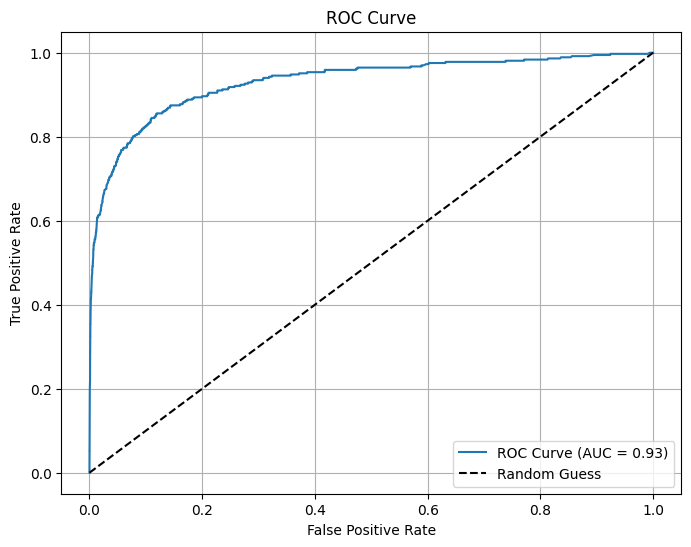

In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC on test set:", auc_score)

# Optional: Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


AUC Score is still very good, didn't decrease that much. I'm good with this trade-off. I'll check the confusion matrix:

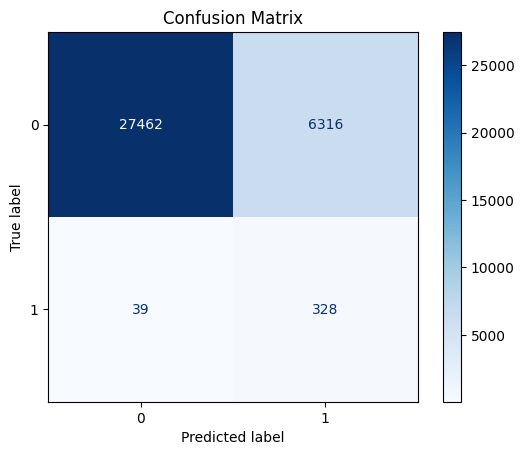

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues', values_format='d')

# Show the plot
import matplotlib.pyplot as plt
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Define cost-benefit values
benefit_tp = 100   # Benefit of correctly predicting churn
cost_fn = -500     # Cost of missing a churner
cost_fp = -20      # Cost of wrongly targeting a non-churner
benefit_tn = 0     # No benefit or cost for correctly predicting no churn